# Data Loader
讀取檔案的function常稱呼為Data Loader。Tensorflow 2.0本身帶有一些程式，可以客製化的讀取檔案，在做Deep Learning時將資料從CPU或硬碟讀取到GPU，使資料能夠與Model參數在GPU上運算。
TF2.0中 tf.data這個庫中的各種class和function就是來幫助各位客製化data loader。

**Data Loader要件:**
1. Dataset物件- 抽取data的來源，可以用各種方式形成，

   可以被iterate(e.g. for x in Dataset)，但不可以被index (e.g. Dataset[3])
2. Dataset操作- 對Dataset以特定方式抽取、分割、合併、加速、映射等等動作，來行程最後訓練、測試用的Data Loader

# Dataset Types

這邊我們先從各種Dataset type開始介紹起

**內容**:
1. From Tensors
2. From Tensor Slices
3. List Files
4. From Generator

In [ ]:
!gdown -q https://drive.google.com/u/0/uc?id=1v8wOZmhcAeZj8ggqq7ZTvK7djNrI1yBM&export=download
!unzip -q example_data.zip

In [1]:
import tensorflow as tf
from tensorflow import data
import numpy as np

## From Tensors

從tensor建立只有一單位資料的Dataset: .from_tensors

In [2]:
dataset=data.Dataset.from_tensors([0,1,2])
for i in dataset:
    print(i)

tf.Tensor([0 1 2], shape=(3,), dtype=int32)


該Dataset只有一個項目，要透過後續操作把項目依照指定方式分開才能後續使用，實際上有點冗贅

使用起來跟tf.constant沒什麼差別

## From Tensor Slices

從tensor建立有數個單位資料的Dataset: .from_tensor_slices

In [3]:
dataset=data.Dataset.from_tensor_slices([0,1,2])
for i in dataset:
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


會依照輸入項目轉成Tensor，再由第0 rank分裂成數個單位，在iterate時會一個個輸出

## List Files

用一列檔案名稱建立Dataset: .list_files

In [4]:
dataset=data.Dataset.list_files("example_data/*.txt")
for i in dataset:
    print(i)

tf.Tensor(b'example_data/1.txt', shape=(), dtype=string)
tf.Tensor(b'example_data/2.txt', shape=(), dtype=string)
tf.Tensor(b'example_data/0.txt', shape=(), dtype=string)
tf.Tensor(b'example_data/3.txt', shape=(), dtype=string)


這種Dataset要求輸入的是file_pattern，可以包含萬用符。
若將檔案化為一個List來做.list_files會變慢

要注意的是，若列舉檔案時要保持檔案順訊，記得要加shuffle=False

In [5]:
dataset=data.Dataset.list_files("example_data/*.txt",shuffle=False)
for i in dataset:
    print(i)

tf.Tensor(b'example_data/0.txt', shape=(), dtype=string)
tf.Tensor(b'example_data/1.txt', shape=(), dtype=string)
tf.Tensor(b'example_data/2.txt', shape=(), dtype=string)
tf.Tensor(b'example_data/3.txt', shape=(), dtype=string)


In [6]:
i.dtype

tf.string

## From Generator

從function建立Dataset: .from_generator

要先建立一個function，且必須要是能iterate的funciton

In [7]:
def f(rng):
    for i in range(rng):
        yield i

In [8]:
dataset=data.Dataset.from_generator(f,output_types=tf.float32,args=[3])
for i in dataset:
    print(i)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


非常活的一種Dataset，可以指定:
1. generator: 使用的funciton，input是什麼output是什麼都可以自己訂，只要是一個iterable function
2. output_types: 輸出的資料型別，會是tensor
3. (optional)args: 代入的arguement
4. (optional)output_shape: output應該什麼形狀，可供檢查用

就算輸出是string也可以，只要output_type有對上就好

In [9]:
def f(rng):
    for i in range(rng):
        yield str(i)

In [10]:
dataset=data.Dataset.from_generator(f,output_types=tf.string,args=[3])
for i in dataset:
    print(i)

tf.Tensor(b'0', shape=(), dtype=string)
tf.Tensor(b'1', shape=(), dtype=string)
tf.Tensor(b'2', shape=(), dtype=string)


如果function是無窮迴圈也可以，但要在後續操作設立停止條件

In [11]:
def f():
    i=0
    while 1:
        i+=1
        yield i

In [12]:
dataset=data.Dataset.from_generator(f,output_types=tf.float32)
for e,i in enumerate(dataset):
    print(e,i)
    if e>=10:
        break

0 tf.Tensor(1.0, shape=(), dtype=float32)
1 tf.Tensor(2.0, shape=(), dtype=float32)
2 tf.Tensor(3.0, shape=(), dtype=float32)
3 tf.Tensor(4.0, shape=(), dtype=float32)
4 tf.Tensor(5.0, shape=(), dtype=float32)
5 tf.Tensor(6.0, shape=(), dtype=float32)
6 tf.Tensor(7.0, shape=(), dtype=float32)
7 tf.Tensor(8.0, shape=(), dtype=float32)
8 tf.Tensor(9.0, shape=(), dtype=float32)
9 tf.Tensor(10.0, shape=(), dtype=float32)
10 tf.Tensor(11.0, shape=(), dtype=float32)


---

# Data Loader- Speedup

剛剛提到Data Loader本身作用是將資料讀取到GPU的記憶體裡。

為後續課程速度，以下會先介紹一些方式將資料被取用的速度加快

**內容**:
* cache
* prefetch

**以tf.data.Dataset.from_generator這種loader類型示範**

先準備好一個data generator，會yield指定數量的數字

In [2]:
def f(rng):
    for i in range(rng):
        yield i

In [3]:
list(f(3))

[0, 1, 2]

## Cache
當資料變多的時候，一次次將資料丟進GPU就顯得越來越慢，這時我們可以使用.cache()

這樣會在每次使用到時，將資料扣留在GPU中，下次再用到時就不用重新丟進GPU

In [6]:
d=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).cache()

In [7]:
%%time
for i,x in enumerate(d):
    if i<3:
        print(x)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
CPU times: user 178 ms, sys: 58.2 ms, total: 236 ms
Wall time: 202 ms


In [8]:
%%time
'''因為第一次跑完存進記憶體，第二次會變快(但因為存起來，有隨機型preprocess的話就不隨機了)'''
for i,x in enumerate(d):
    if i<3:
        print(x)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
CPU times: user 87.7 ms, sys: 0 ns, total: 87.7 ms
Wall time: 85.5 ms


---

## Prefetch
cache是針對已跑過資料，那如果需要不斷的更新資料(例如使用random augmentation)，那樣就無法使用cache

這時可以用prefetch，將資料分時多工地丟進GPU，這樣在準備下一筆資料時，上筆資料正準備丟進GPU，不會浪費時間。

未使用prefetch:

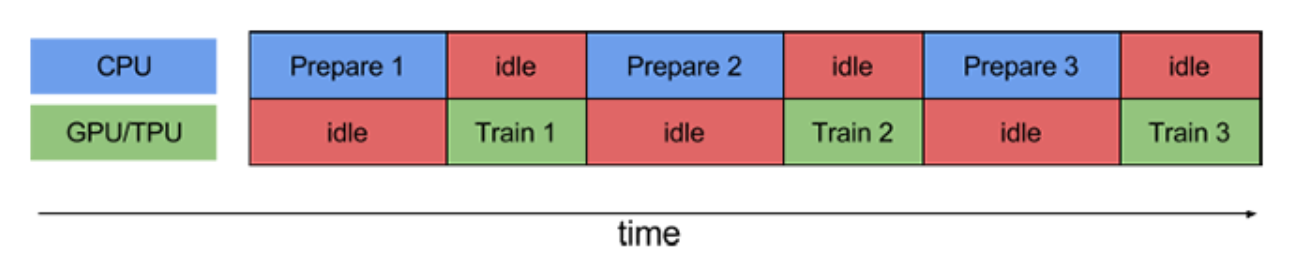

使用prefetch

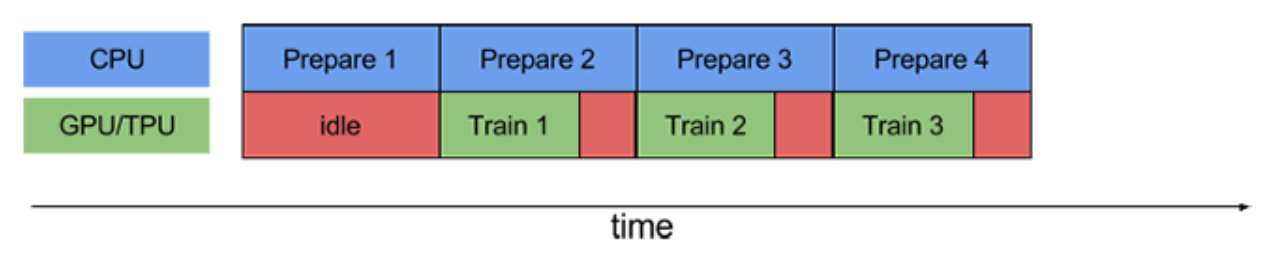

In [9]:
'''在跑的過程中pipeline處理，一部分先放進memory內'''
d0=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32)
d1=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).prefetch(10)
d2=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).prefetch(100)
d3=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
%%time
for i in d0:
    pass

CPU times: user 198 ms, sys: 36.7 ms, total: 234 ms
Wall time: 200 ms


In [11]:
%%time
'''加完快一點'''
for i in d1:
    pass

CPU times: user 199 ms, sys: 68.1 ms, total: 267 ms
Wall time: 177 ms


In [12]:
%%time
'''加越多越快'''
for i in d2:
    pass

CPU times: user 211 ms, sys: 52.8 ms, total: 264 ms
Wall time: 179 ms


In [13]:
%%time
'''Autotune很容易達到很快'''
for i in d3:
    pass

CPU times: user 208 ms, sys: 58.3 ms, total: 266 ms
Wall time: 177 ms


In [14]:
'''含有cache的情況也是可以加速'''
d0=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().repeat(100)
d1=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().repeat(100).prefetch(10)
d2=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().repeat(100).prefetch(100)
d3=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().repeat(100).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
for i in d0:
    pass
for i in d1:
    pass
for i in d2:
    pass
for i in d3:
    pass

In [16]:
%%time
for i in d0:
    pass

CPU times: user 88.4 ms, sys: 0 ns, total: 88.4 ms
Wall time: 86.2 ms


In [17]:
%%time
'''加完快一點'''
for i in d1:
    pass

CPU times: user 97.5 ms, sys: 1.73 ms, total: 99.2 ms
Wall time: 90.3 ms


In [18]:
%%time
'''加越多越快'''
for i in d2:
    pass

CPU times: user 94 ms, sys: 4.45 ms, total: 98.4 ms
Wall time: 89.9 ms


In [19]:
%%time
'''Autotune很容易達到很快，而且記憶體也不會讓他爆'''
for i in d3:
    pass

CPU times: user 89.1 ms, sys: 9.27 ms, total: 98.3 ms
Wall time: 89.5 ms


---

# Dataset Operations
有了基本的Dataset物件，我們可以對它做各種操作，組成我們一次想丟進model裡面的資料組合。

以下先介紹其中一部分操作。

**內容**:
* batch
* repeat
* shuffle
* filter
* take/skip
* map

## Batch
批次執行

In [6]:
'''直接開超過1就好'''
d=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(2)

In [7]:
%%time
for i,x in enumerate(d):
    if i<3:
        print(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 5.], dtype=float32)>
CPU times: user 159 ms, sys: 51.3 ms, total: 210 ms
Wall time: 171 ms


In [8]:
'''開越多會更快'''
d0=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(3)
d1=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(10)

In [9]:
%%time
for i,x in enumerate(d0):
    if i<3:
        print(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 7., 8.], dtype=float32)>
CPU times: user 137 ms, sys: 61.7 ms, total: 198 ms
Wall time: 157 ms


In [10]:
%%time
for i,x in enumerate(d1):
    if i<3:
        print(x)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)>
<tf.Tensor: shape=(10,), dtype=float32, numpy=array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.], dtype=float32)>
<tf.Tensor: shape=(10,), dtype=float32, numpy=array([20., 21., 22., 23., 24., 25., 26., 27., 28., 29.], dtype=float32)>
CPU times: user 102 ms, sys: 77.1 ms, total: 179 ms
Wall time: 136 ms


In [11]:
'''到某個程度後邊際效應遞減'''
d0=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(10)
d1=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(100)
d2=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(200)

In [12]:
%%time
for i,x in enumerate(d0):
    pass

CPU times: user 141 ms, sys: 33.8 ms, total: 175 ms
Wall time: 132 ms


In [13]:
%%time
for i,x in enumerate(d1):
    pass

CPU times: user 115 ms, sys: 49.8 ms, total: 165 ms
Wall time: 121 ms


In [14]:
%%time
for i,x in enumerate(d2):
    pass

CPU times: user 94 ms, sys: 71.8 ms, total: 166 ms
Wall time: 121 ms


In [15]:
d1=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).batch(2)
d2=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).batch(2,drop_remainder=True)

In [16]:
%%time
'''如果長度不能被batch size除盡，會有殘量'''
for i,x in enumerate(d1):
    print(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>
CPU times: user 26.6 ms, sys: 38.6 ms, total: 65.2 ms
Wall time: 62.1 ms


In [17]:
%%time
'''drop_remainder會把殘量丟掉，適合某些長度需要一致的場合'''
for i,x in enumerate(d2):
    print(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
CPU times: user 17.3 ms, sys: 46.6 ms, total: 63.9 ms
Wall time: 61.4 ms


## Repeat
將Dataset重複數次

In [18]:
d=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).repeat(2)

In [19]:
%%time
'''把指定的loader重複數次'''
for i,x in enumerate(d):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
CPU times: user 25.7 ms, sys: 93.6 ms, total: 119 ms
Wall time: 116 ms


In [20]:
d=tf.data.Dataset.from_generator(f,args=[9],output_types=tf.float32).batch(3).repeat(2)

In [21]:
%%time
'''如果前面有batch過就，重複的項目也有batch'''
for i,x in enumerate(d):
    print(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 7., 8.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 7., 8.], dtype=float32)>
CPU times: user 49.3 ms, sys: 60.5 ms, total: 110 ms
Wall time: 106 ms


In [22]:
d=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).batch(2).repeat(2)

In [23]:
%%time
'''如果前面有batch有殘量，重複的也有殘量'''
for i,x in enumerate(d):
    print(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>
CPU times: user 38.1 ms, sys: 81.8 ms, total: 120 ms
Wall time: 117 ms


In [24]:
d1=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).repeat(2).cache()
d2=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).cache().repeat(2)

In [25]:
%%time
'''如果先repeat 再cache,則兩次都是第一次速度'''
for i,x in enumerate(d1):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
CPU times: user 34.8 ms, sys: 86.2 ms, total: 121 ms
Wall time: 119 ms


In [26]:
%%time
'''如果先cache再repeat,則第二次會被加速'''
for i,x in enumerate(d2):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
CPU times: user 5.53 ms, sys: 59.9 ms, total: 65.4 ms
Wall time: 62.5 ms


## Shuffle

以特定方式將Dataset抽出順序打亂

1. 把前buffer_size個先存起來
2. 從buffer_size裡面任抽一個輸出
3. 把buffer_size後面一個塞進buffer理
4. 重複2~3直到所有數字被抽出

[reference](https://zhuanlan.zhihu.com/p/42417456)

In [29]:
d1=tf.data.Dataset.from_generator(f,args=[5],output_types=tf.float32).shuffle(buffer_size=1)
'''如果buffer_size開1，就沒有亂抽到'''
for i,x in enumerate(d1):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
<tf.Tensor: shape=(), dtype=float32, numpy=4.0>


In [30]:
d2=tf.data.Dataset.from_generator(f,args=[5],output_types=tf.float32).shuffle(buffer_size=2)
'''如果buffer_size開2，有亂抽到'''
for i,x in enumerate(d2):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
<tf.Tensor: shape=(), dtype=float32, numpy=4.0>


In [31]:
'''可是這個buffer如果小於前面的資料數，那亂的程度就會受到影響'''
d=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().shuffle(3).batch(10).repeat(1000)

In [32]:
l=[]
for i in d:
    l.append(i)
a=tf.stack(l,axis=-1)

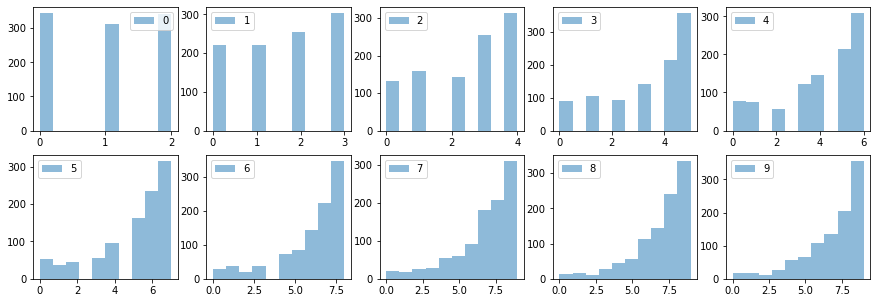

In [33]:
'''統計一下會發現，batch第一次抽到的可能性只落在三種選擇內，第二次的是4種，依此類推，越後面的越容易在更後面抽到'''
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [34]:
'''如果buffer數到了一定數量就比較好用一點'''
d=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().shuffle(8).batch(10).repeat(1000)

In [35]:
%%time
l=[]
for i in d:
    l.append(i)
a=tf.stack(l,axis=-1)

CPU times: user 182 ms, sys: 69.1 ms, total: 251 ms
Wall time: 228 ms


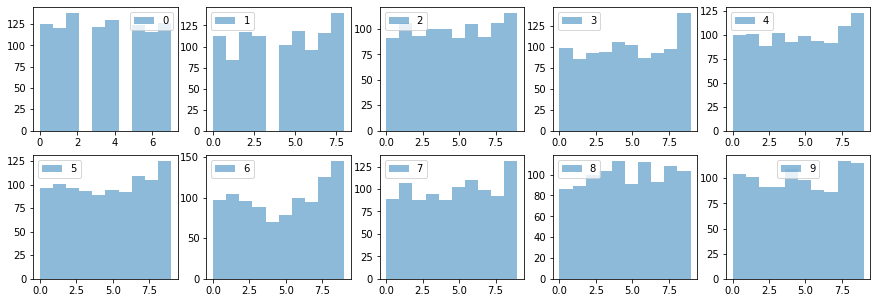

In [36]:
'''雖然前幾次的會不太隨機，但是後面的都很隨機'''
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [37]:
'''如果buffer開到滿就每次都隨機'''
d=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().shuffle(10).batch(10).repeat(1000)

In [38]:
%%time
l=[]
for i in d:
    l.append(i)
a=tf.stack(l,axis=-1)

CPU times: user 194 ms, sys: 60.6 ms, total: 254 ms
Wall time: 229 ms


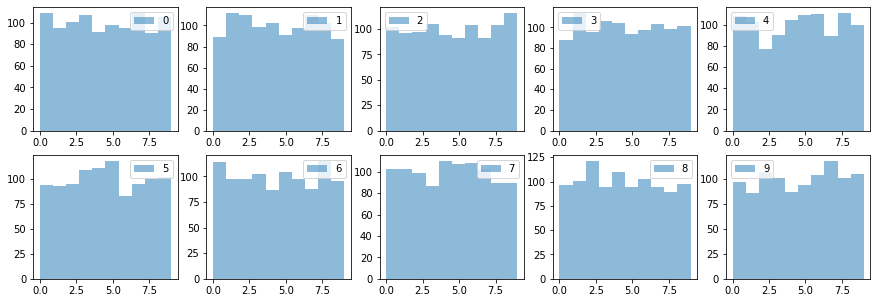

In [39]:
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [40]:
'''如果buffer開到滿就每次都隨機'''
d0=tf.data.Dataset.from_generator(f,args=[10000],output_types=tf.float32).cache().shuffle(2).batch(10000).repeat(1000)
d1=tf.data.Dataset.from_generator(f,args=[10000],output_types=tf.float32).cache().shuffle(2000).batch(10000).repeat(1000)
d2=tf.data.Dataset.from_generator(f,args=[10000],output_types=tf.float32).cache().shuffle(10000).batch(10000).repeat(1000)

In [41]:
%%time
for i in d0:
    pass

CPU times: user 15.8 s, sys: 176 ms, total: 15.9 s
Wall time: 15.5 s


In [42]:
%%time
for i in d1:
    pass

CPU times: user 17 s, sys: 185 ms, total: 17.2 s
Wall time: 16.8 s


In [43]:
%%time
for i in d2:
    pass

CPU times: user 17.1 s, sys: 194 ms, total: 17.3 s
Wall time: 16.8 s


**重點是也沒有比只使用0.2倍的buffer_size慢**

**所以有想用shuffle記得buffer開滿，除非想依照class sample數量做balancing**

## Filter
將一部分符合判斷式的資料抽出

In [44]:
'''篩選data'''
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).filter(lambda x:x>=3)

In [45]:
'''依指定判斷式比對'''
for i,x in enumerate(d):
    print(x)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)


In [46]:
'''篩選data'''
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).batch(2).filter(lambda x:x>2)

In [49]:
'''不能夠filter vector'''
try:
    for i,x in enumerate(d):
        print(x)
except:
    print("error")

error


## Take, Skip

In [4]:
d=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32)

In [5]:
%%time
'''Take可以擷取dataset一部分'''
for i,x in enumerate(d.take(3)):
        print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
CPU times: user 25.9 ms, sys: 25.2 ms, total: 51.1 ms
Wall time: 48.7 ms


In [6]:
%%time
for i,x in enumerate(d.take(4)):
        print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
CPU times: user 28.4 ms, sys: 21.8 ms, total: 50.2 ms
Wall time: 47.6 ms


In [7]:
%%time
'''Skip可以跳過dataset一部分'''
for i,x in enumerate(d.skip(5)):
        print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>
<tf.Tensor: shape=(), dtype=float32, numpy=6.0>
<tf.Tensor: shape=(), dtype=float32, numpy=7.0>
<tf.Tensor: shape=(), dtype=float32, numpy=8.0>
<tf.Tensor: shape=(), dtype=float32, numpy=9.0>
CPU times: user 23.4 ms, sys: 29.1 ms, total: 52.5 ms
Wall time: 49.6 ms


In [8]:
%%time
'''Skip可以跳過dataset一部分'''
for i,x in enumerate(d.skip(6)):
        print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>
<tf.Tensor: shape=(), dtype=float32, numpy=7.0>
<tf.Tensor: shape=(), dtype=float32, numpy=8.0>
<tf.Tensor: shape=(), dtype=float32, numpy=9.0>
CPU times: user 23.3 ms, sys: 35.5 ms, total: 58.7 ms
Wall time: 55.7 ms


## Map

In [9]:
'''套用指定算式做前處理，例如一開始是檔案名稱的dataset，可依序讀檔，前處理'''
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).map(lambda x:x*2)

In [10]:
'''依指定算式做前處理'''
for i,x in enumerate(d):
    print(x)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(10.0, shape=(), dtype=float32)


In [11]:
d1=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).map(lambda x:x*2)
d2=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).map(lambda x:x*2,num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
%%time
for i,x in enumerate(d1):
    pass

CPU times: user 225 ms, sys: 84.8 ms, total: 310 ms
Wall time: 250 ms


In [13]:
%%time
'''使用num_parallel_calls做平行化會快一點'''
for i,x in enumerate(d2):
    pass

CPU times: user 225 ms, sys: 97.2 ms, total: 322 ms
Wall time: 204 ms


---

# Multi- Dataset Opeerations
這邊介紹更多操作，其中有一部分需要用到兩個以上的Dataset

**內容**:
* zip
* concatenate

## zip

In [14]:
'''把兩個dataset的資料並聯，可用於data跟label相並'''
d0=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).shuffle(3)
d1=tf.data.Dataset.from_generator(f,args=[4],output_types=tf.float32)
d2=tf.data.Dataset.zip((d0,d1))

In [15]:
%%time
'''數量對不上時，最後面的會被砍掉'''
for i,x in enumerate(d2):
    print(x)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)
(<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>)
CPU times: user 58.9 ms, sys: 79.1 ms, total: 138 ms
Wall time: 134 ms


## Concatenate

In [16]:
'''把兩個dataset接起來'''
d0=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).shuffle(3)
d1=tf.data.Dataset.from_generator(f,args=[4],output_types=tf.float32)
d2=tf.data.Dataset.concatenate(d0,d1)

In [17]:
%%time
for i,x in enumerate(d0):
    print(x)
for i,x in enumerate(d1):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
CPU times: user 37.1 ms, sys: 88.2 ms, total: 125 ms
Wall time: 123 ms


In [18]:
%%time
'''接起來可能會稍慢但是很方便'''
for i,x in enumerate(d2):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
CPU times: user 38.6 ms, sys: 85.2 ms, total: 124 ms
Wall time: 120 ms


In [19]:
'''不過有繼承cache所以如果有先pre-run過就沒差太多'''
d0=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).shuffle(3).cache()
d1=tf.data.Dataset.from_generator(f,args=[4],output_types=tf.float32).cache()
d2=tf.data.Dataset.concatenate(d0,d1)

In [20]:
%%time
'''兩個分開跑'''
for i,x in enumerate(d0):
    print(x)
for i,x in enumerate(d1):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
CPU times: user 37.9 ms, sys: 88.9 ms, total: 127 ms
Wall time: 124 ms


In [21]:
%%time
'''跑concate起來的，因為兩個都有pre-run過所以很快'''
for i,x in enumerate(d2):
    print(x)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
CPU times: user 13.5 ms, sys: 3.48 ms, total: 17 ms
Wall time: 13.7 ms


---

## *較少用到的東西*

## Window

In [50]:
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).window(3)

In [51]:
%%time
'''把loader分成數組loaders，每組固定數量，可能用在切分class資料'''
for i,w in enumerate(d):
    print(i)
    for x in w:
        print(x)

0
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
1
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
<tf.Tensor: shape=(), dtype=float32, numpy=4.0>
<tf.Tensor: shape=(), dtype=float32, numpy=5.0>
CPU times: user 23.1 ms, sys: 48 ms, total: 71.1 ms
Wall time: 68.6 ms


In [52]:
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).batch(2).window(2)

In [53]:
%%time
'''也可以先做好batch再分組'''
for i,w in enumerate(d):
    print(i)
    for x in w:
        print(x)

0
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>
1
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 5.], dtype=float32)>
CPU times: user 30.7 ms, sys: 40.4 ms, total: 71 ms
Wall time: 68.4 ms
